In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import uncertainties.unumpy as unp
from uncertainties import ufloat, correlated_values_norm, correlated_values, covariance_matrix, correlation_matrix
from iminuit import Minuit
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import gvar

In [3]:
from academy.rates.BtoV import BtoV
from academy.formfactors.BGL import BToDStarBGL
from academy.formfactors.CLN import BToDStarCLN

In [4]:
tauBzero = 1.520e-12 * 1. / 6.582119e-16 / 1e-9
tauBplus = 1.638e-12 * 1. / 6.582119e-16 / 1e-9

# Inputs

We load more than we need for this example down below. But these code snippets to load the lattice data can be used later when implementing your own fits with lattice constraints.

## Fit Results

In [22]:
data = np.array(correlated_values(
    np.load("output/Unfolding/data/minv_central_values_full.npy"),
    np.load("output/Unfolding/data/minv_covariance_full.npy")
))

In [81]:
data_shape = np.array([
    *(data[ 0:10] / sum(data[ 0:10])),
    *(data[10:20] / sum(data[10:20])),
    *(data[20:30] / sum(data[20:30])),
    *(data[30:40] / sum(data[30:40])),
])

data_norm = np.array([
    (sum(data[ 0:10]) + sum(data[10:20])) / 2,
    (sum(data[20:30]) + sum(data[30:40])) / 2
])

## Lattice 2014

This is a single data point at zero-recoil for h_A1. https://arxiv.org/pdf/1403.0635.pdf

In [5]:
hA1_2014 = ufloat(0.906 , (0.004**2 + 0.012**2)**0.5)
hA1_2014

0.906+/-0.012649110640673518

## New Lattice Results

These results are on arXiv, but not published yet. They provide data points with correlations for the form factors directly, and in the form of BGL coefficients. We will use the latter to initialize an effort2 class and plot the distributions.

In [6]:
lattice = gvar.gload("lattice_data/SynthData.PyDat")
#for x in lattice:
#    print(f"{x} = {ufloat(gvar.mean(lattice[x]), gvar.sdev(lattice[x]))}")

In [7]:
g_all = [lattice["g(1.03)"], lattice["g(1.10)"], lattice["g(1.17)"]]
g_all = correlated_values(
    gvar.mean(g_all),
    gvar.evalcov(g_all)
)

f_all = [lattice["f(1.03)"], lattice["f(1.10)"], lattice["f(1.17)"]]
f_all = correlated_values(
    gvar.mean(f_all),
    gvar.evalcov(f_all)
)

F1_all = [lattice["F1(1.03)"], lattice["F1(1.10)"], lattice["F1(1.17)"]]
F1_all = correlated_values(
    gvar.mean(F1_all),
    gvar.evalcov(F1_all)
)

In [8]:
lattice2 = gvar.gload("lattice_data/FitResults.PyDat")
#for x in lattice2:
#    print(f"{x} = {ufloat(gvar.mean(lattice2[x]), gvar.sdev(lattice2[x]))}")
    
lattice_coefficients = [
    lattice2["LQCD_a0"],
    lattice2["LQCD_a1"],
    lattice2["LQCD_a2"],
    lattice2["LQCD_b0"],
    lattice2["LQCD_b1"],
    lattice2["LQCD_b2"],
    lattice2["LQCD_c1"],
    lattice2["LQCD_c2"],
]

lattice_coefficients = correlated_values(
    gvar.mean(lattice_coefficients),
    gvar.evalcov(lattice_coefficients)
)

In [9]:
hA1 = ufloat(lattice["hA1(1.00)"].mean, lattice["hA1(1.00)"].sdev)

hA1_all = [lattice["hA1(1.03)"], lattice["hA1(1.10)"], lattice["hA1(1.17)"]]
hA1_all = correlated_values(
    gvar.mean(hA1_all),
    gvar.evalcov(hA1_all)
)

In [10]:
def make_plot_pretty(ax, bin_edges_all):
    
    tmp = {}
    for voi in fit_vois:
        tmp[voi] = np.array([(lower, upper) for lower, upper in zip(bin_edges_all[voi], bin_edges_all[voi][1:])])
    tmp = np.array([b for voi in fit_vois for b in tmp[voi]])
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(tmp)))
    # ... and label them with the respective list entries
    ax.set_xticklabels([f"[{lower:.2f}, {upper:.2f}]" for lower, upper in tmp], rotation=90, fontsize=6)
    ax.xaxis.set_minor_locator(MultipleLocator(1))

    ax.set_xlim(-0.5, 19.5)

    ax.axvline(9.5, color="black")

    ax.text(0.00+0.12, 1.02, r"$w$", fontsize=10, transform=ax.transAxes)
    ax.text(0.55+0.08, 1.02, r"$\cos \theta_\ell$", fontsize=10, transform=ax.transAxes)
    
    ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper left')
    return ax

markers = {
    15: "v",
    16: "s",
    # (15, 16): "o",
    17: "o",
    18: "X",
    # (17, 18): "o"
    
}

bin_edges_wReco = np.array([*np.linspace(1.0, 1.45, num=10), 1.504]) 
bin_edges_costhetalReco = np.array([*np.linspace(-1, 1, num=11)])

bin_edges_all = { 
    "wReco": bin_edges_wReco,
    "costhetalReco": bin_edges_costhetalReco,
}

fit_vois = ["wReco", "costhetalReco"]

# Initialize and Use the eFFORT Class

Definitions of masses

In [11]:
m_Bzero = 5.27963
m_Bplus = 5.27932
m_Dstarzero = 2.00685
m_Dstarplus = 2.01026

Initialize a FF class, and then a rate class with our defined form factor.

In [12]:
BzeroToDStarBGLLattice = BToDStarBGL(
    m_B=m_Bzero,
    m_V=m_Dstarplus,
    exp_coeff_a = lattice_coefficients[0:3],
    exp_coeff_b = lattice_coefficients[3:6],
    exp_coeff_c = lattice_coefficients[6:],
)

rate_lattice = BtoV(BzeroToDStarBGLLattice, Vcb=1)

Do the calculation first, then plot later.

In [43]:
w_edges = np.array([1.00000001, 1.05, 1.10, 1.15, 1.20, 1.25, 1.30, 1.35, 1.40, 1.45, 1.503549794359789])
cosTheteaL_edges = np.linspace(-1, 1, 11)

In [13]:
w_range = np.linspace(*rate_lattice.FF.kinematics.w_range_numerical_stable)
cosL_range = np.linspace(*rate_lattice.FF.kinematics.cosL_range)

In [35]:
total_rate_lattice = rate_lattice.Gamma()
w_rate_lattice = [rate_lattice.dGamma_dw(w) / total_rate_lattice       * (max(w_range) - min(w_range))       for w in w_range]
cosL_rate_lattice = [rate_lattice.dGamma_dcosL(w) / total_rate_lattice * (max(cosL_range) - min(cosL_range)) for w in cosL_range]

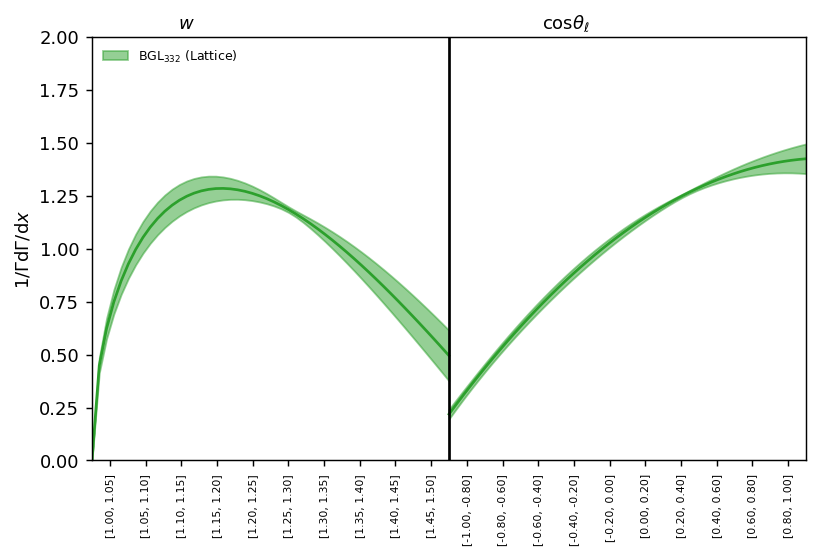

In [54]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

ax.plot(np.linspace( 0-0.5, 10-0.5), unp.nominal_values(w_rate_lattice), color="tab:green")
ax.fill_between(
    np.linspace( 0-0.5, 10-0.5), 
    unp.nominal_values(w_rate_lattice) + unp.std_devs(w_rate_lattice),
    unp.nominal_values(w_rate_lattice) - unp.std_devs(w_rate_lattice),
    alpha=0.5, color="tab:green", label=r"BGL$_{332}$ (Lattice)"
)
ax.plot(np.linspace(10-0.5, 20-0.5), unp.nominal_values(cosL_rate_lattice), color="tab:green")
ax.fill_between(
    np.linspace(10-0.5, 20-0.5),
    unp.nominal_values(cosL_rate_lattice) + unp.std_devs(cosL_rate_lattice),
    unp.nominal_values(cosL_rate_lattice) - unp.std_devs(cosL_rate_lattice),
    alpha=0.5, color="tab:green"
)

make_plot_pretty(ax, bin_edges_all)
ax.set_ylim(0, 2)
ax.set_ylabel(r"$1 / \Gamma \mathrm{d} \Gamma / \mathrm{d}x$")
plt.tight_layout()
plt.show()
plt.close()

# Fitting The Spectrum

## Calculate a Prediction

First exercise: Plot the prediction for the rate in bins of w, cosThetaL, cosThetaV, and chi. This can be used later when implementing your chi2 fit.

Let us initialize a new class for fitting, where we will vary the coefficients away from the lattice coefficients. As starting values, use the lattice

In [55]:
BzeroToDStarBGLFit = BToDStarBGL(
    m_B=m_Bzero,
    m_V=m_Dstarplus,
    exp_coeff_a = lattice_coefficients[0:3],
    exp_coeff_b = lattice_coefficients[3:6],
    exp_coeff_c = lattice_coefficients[6:],
)

rate_fit = BtoV(BzeroToDStarBGLFit, Vcb=1)

In [56]:
# Integration close to the boundaries is problematic, hence we go epsilon away from it
BzeroToDStarBGLFit.kinematics.w_range_numerical_stable

(1.00000001, 1.503549794359789)

In [57]:
def prediction_shape(x):
    """Make a prediction for the shape given the coefficients and Vcb.
    
    x = [a0, a1, a2, b0, b1, b2, c1, c2, c3, Vcb]
    """
    rate_fit.FF.set_expansion_coefficients(x[:3], x[3:6], x[6:9])
    rate_fit.Vcb = x[-1]
    total_rate = rate_fit.Gamma()
    prediction = np.array([
        [rate_fit.DGamma_Dw(l, u) / (u-l) * (w_edges[-1] - w_edges[0]) for l, u in zip(w_edges, w_edges[1:])],
        [rate_fit.DGamma_DcosL(l, u) / (u-l) * (cosTheteaL_edges[-1] - cosTheteaL_edges[0]) for l, u in zip(cosTheteaL_edges, cosTheteaL_edges[1:])],
    ]).flatten() / total_rate
    
    # Calculate the prediction in 20 bins, 10 for w, 10 for cosThetaL
    return prediction

In [58]:
x0 = np.array([*lattice_coefficients, 0, 1])  # [a0, a1, a2, b0, b1, b2, c1, c2, c3=0, Vcb=1]
myPrediction = prediction_shape(x0)

In [67]:
unp.nominal_values(data_shape[ 0:10]) / np.array([(u-l) / (w_edges[-1] - w_edges[0]) for l, u in zip(w_edges, w_edges[1:])])

array([0.51542205, 1.03841098, 0.97044521, 1.25738917, 1.18519459,
       1.19405487, 1.14908252, 0.9997729 , 0.93248541, 0.77380138])

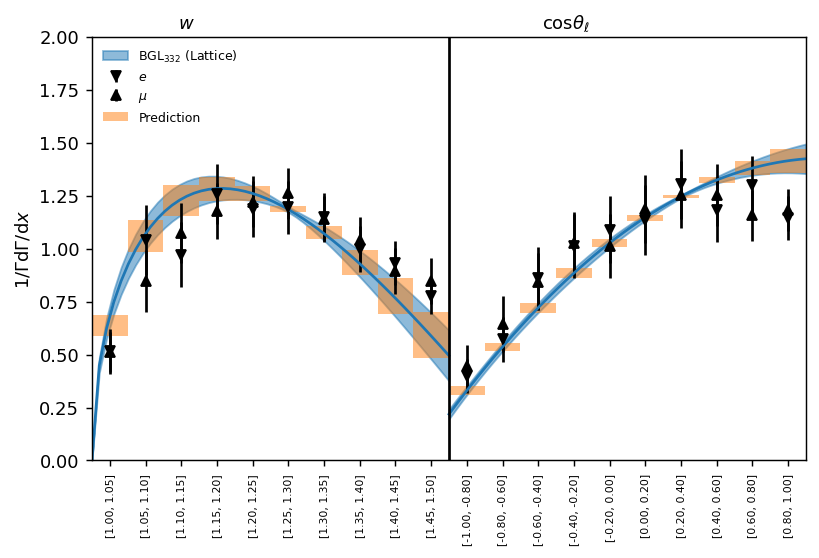

In [83]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

ax.errorbar(
    range(0, 10),
    y=unp.nominal_values(data_shape[ 0:10]) / np.array([(u-l) / (w_edges[-1] - w_edges[0]) for l, u in zip(w_edges, w_edges[1:])]),
    yerr=unp.std_devs(data_shape[ 0:10]) / np.array([(u-l) / (w_edges[-1] - w_edges[0]) for l, u in zip(w_edges, w_edges[1:])]),
    marker="v", ls="", color="black", label=r"$e$"
)

ax.errorbar(
    range(10, 20),
    y=unp.nominal_values(data_shape[10:20]) / np.array([(u-l) / (cosTheteaL_edges[-1] - cosTheteaL_edges[0]) for l, u in zip(cosTheteaL_edges, cosTheteaL_edges[1:])]),
    yerr=unp.std_devs(data_shape[10:20]) / np.array([(u-l) / (cosTheteaL_edges[-1] - cosTheteaL_edges[0]) for l, u in zip(cosTheteaL_edges, cosTheteaL_edges[1:])]),
    marker="v", ls="", color="black"
)


ax.errorbar(
    range(0, 10),
    y=unp.nominal_values(data_shape[20:30]) / np.array([(u-l) / (w_edges[-1] - w_edges[0]) for l, u in zip(w_edges, w_edges[1:])]),
    yerr=unp.std_devs(data_shape[20:30]) / np.array([(u-l) / (w_edges[-1] - w_edges[0]) for l, u in zip(w_edges, w_edges[1:])]),
    marker="^", ls="", color="black", label=r"$\mu$"
)

ax.errorbar(
    range(10, 20),
    y=unp.nominal_values(data_shape[30:40]) / np.array([(u-l) / (cosTheteaL_edges[-1] - cosTheteaL_edges[0]) for l, u in zip(cosTheteaL_edges, cosTheteaL_edges[1:])]),
    yerr=unp.std_devs(data_shape[30:40]) / np.array([(u-l) / (cosTheteaL_edges[-1] - cosTheteaL_edges[0]) for l, u in zip(cosTheteaL_edges, cosTheteaL_edges[1:])]),
    marker="^", ls="", color="black"
)

ax.plot(np.linspace( 0-0.5, 10-0.5), unp.nominal_values(w_rate_lattice), color="tab:blue")
ax.fill_between(
    np.linspace( 0-0.5, 10-0.5), 
    unp.nominal_values(w_rate_lattice) + unp.std_devs(w_rate_lattice),
    unp.nominal_values(w_rate_lattice) - unp.std_devs(w_rate_lattice),
    alpha=0.5, color="tab:blue", label=r"BGL$_{332}$ (Lattice)"
)
ax.plot(np.linspace(10-0.5, 20-0.5), unp.nominal_values(cosL_rate_lattice), color="tab:blue")
ax.fill_between(
    np.linspace(10-0.5, 20-0.5),
    unp.nominal_values(cosL_rate_lattice) + unp.std_devs(cosL_rate_lattice),
    unp.nominal_values(cosL_rate_lattice) - unp.std_devs(cosL_rate_lattice),
    alpha=0.5, color="tab:blue"
)

ax.bar(range(20), width=1, bottom=unp.nominal_values(myPrediction) - unp.std_devs(myPrediction), height=2*unp.std_devs(myPrediction), color="tab:orange", alpha=0.5, label="Prediction")

make_plot_pretty(ax, bin_edges_all)
ax.set_ylim(0, 2)
ax.set_ylabel(r"$1 / \Gamma \mathrm{d} \Gamma / \mathrm{d}x$")
plt.tight_layout()
plt.show()
plt.close()

In [22]:
def prediction_rate(x):
    """Make a prediction for the absolute rate given the coefficients and Vcb.
    
    x = [a0, a1, a2, b0, b1, b2, c1, c2, c3, Vcb]
    """
    rate_fit.FF.set_expansion_coefficients(x[:3], x[3:6], x[6:9])
    rate_fit.Vcb = x[-1]
    return rate_fit.Gamma()

In [23]:
def prediction_form_factor(x):
    """Make a prediction for hA1 given the coefficients and Vcb.
    
    x = [a0, a1, a2, b0, b1, b2, c1, c2, c3, Vcb]
    """
    rate_fit.FF.set_expansion_coefficients(x[:3], x[3:6], x[6:9])
    rate_fit.Vcb = x[-1]
    return rate_fit.FF.h_A1(1)

## Chi2

Next we need to implement our chi2 function. It has the form

$\chi^2 = \chi^2_\mathrm{Shape} + \chi^2_\mathrm{Norm} + \chi^2_\mathrm{Lattice}$

We calculated the shape already, so let us start with that one.

In [24]:
def chi2(a0, a1, a2, b0, b1, b2, c1, c2, c3, Vcb):
    x = np.array([a0, a1, a2, b0, b1, b2, c1, c2, c3, Vcb])
    
    # chi2_shape = ...
    # chi2_norm = ...
    # chi2_lattice =  ...
    
    return 0  # sum of chi2

Number of coefficients for each form factor. Right now we use the numbers given by the lattice, but depending on the sensitivity of the data, the number of parameters has to be decreased to prevent overfitting.

In [25]:
a = 3
b = 3
c = 2

In [29]:
m = Minuit(chi2, 
    a0=lattice_coefficients[0].n if a >= 1 else 0,
    a1=lattice_coefficients[1].n if a >= 2 else 0,
    a2=lattice_coefficients[2].n if a >= 3 else 0,
    b0=lattice_coefficients[3].n if b >= 1 else 0,
    b1=lattice_coefficients[3].n if b >= 2 else 0,
    b2=lattice_coefficients[5].n if b >= 3 else 0,
    c1=lattice_coefficients[6].n if c >= 1 else 0,
    c2=lattice_coefficients[7].n if c >= 2 else 0,
    c3=0,
    Vcb=1,
  )

m.fixed["a0"] = True if a <= 0 else False
m.fixed["b0"] = True if b <= 0 else False
m.fixed["c1"] = True if c <= 0 else False

m.fixed["a1"] = True if a <= 1 else False
m.fixed["b1"] = True if b <= 1 else False
m.fixed["c2"] = True if c <= 1 else False

m.fixed["a2"] = True if a <= 2 else False
m.fixed["b2"] = True if b <= 2 else False
m.fixed["c3"] = True if c <= 2 else False

m.simplex()
m.migrad() 
m.hesse()  
m

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0                          │              Nfcn = 294              │
│ EDM = 0 (Goal: 0.0002)           │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   Hesse FAILED   │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a0   │ 3.3032e-2 │ 0.0000e-2 │            │            │         │         │       │
│ 1 │ a1   │ -1.552e-1 │ 0.000e-1  │            │            │         │         │       │
│ 2 │ a2   │-1.2286e-1 │ 0.0000e-1 │            │            │         │         │       │
│ 3 │ b0   │ 1.2292e-2 │ 0.0000e-2 │            │            │         │         │       │
│ 4 │ b1   │ 1.2292e-2 │ 0.0000e-2 │            │            │         │         │       │
│ 5 │ b2   │ 6.7672e-2 │ 0.0000e-2 │            │            │         │         │       │
│ 6 │ c1   │-5.7789e-3 │ 0.0000e-3 │            │            │         │         │       │
│ 7 │ c2   │-1.2607e-2 │ 0.0000e-2 │            │            │         │         │       │
│ 8 │ c3   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 9 │ Vcb  │     1     │     0     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘